In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

In [199]:
from_date = datetime.datetime(2010, 6, 29) # 1277769600
today = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
csv_file = 'https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=' + from_date.strftime('%s') + '&period2=' + today.strftime('%s') + '&interval=1d&events=history&includeAdjustedClose=true'
local_file = '../data/tsla_HistoricalData.csv'
max_age = datetime.timedelta(days=1)
if os.path.exists(local_file) or today - datetime.datetime.fromtimestamp(os.path.getmtime(local_file)) > max_age:
    print('Using local file')
else:
    print('Downloading file')
    import urllib.request
    urllib.request.urlretrieve(csv_file, local_file)
df = pd.read_csv(csv_file, encoding='cp1252', usecols=['Date', 'Adj Close'])


Using local file


In [200]:
df.rename(columns={'Price': 'Pre-split Price'}, inplace=True)
df.rename(columns={'Adj Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_values(by='Date', ascending=True, inplace=True)
df.head()

,Price
Date,
2010-06-29,1.592667
2010-06-30,1.588667
2010-07-01,1.464000
2010-07-02,1.280000
2010-07-06,1.074000


In [201]:
# Given price targets data is manually collected it is easier to use a markdown table than csv file
csv_file = '../data/tsla_PriceTargets.md'
# Read markdown table as csv format with '|' as separator and skip the row of '----' separators
dfTargets = pd.read_csv('../data/tsla_PriceTargets.md', sep='|', skipinitialspace=True, skiprows=[1])
# Drop the first and last (empty) columns due to how the markdown table is imported
dfTargets = dfTargets.iloc[:, 1:-1]  
# Remove leading/trailing white spaces from column names
dfTargets.columns = dfTargets.columns.str.strip()
# Remove leading/trailing white spaces from data
dfTargets = dfTargets.applymap(lambda x: x.strip() if isinstance(x, str) else x)
dfTargets['Date'] = pd.to_datetime(dfTargets['TargetDate'],dayfirst=True)
dfTargets['ForecastDate'] = pd.to_datetime(dfTargets['ForecastDate'],dayfirst=True)
dfTargets.set_index('Date', inplace=True)
dfTargets = dfTargets.sort_index()
#print(dfOther.columns)


In [202]:
def adjust_price(row, date, multiplier):
    if row['ForecastDate'] < pd.to_datetime(date):
        row['Bear'] = (row['Bear'] / multiplier)
        row['Base'] = (row['Base'] / multiplier)
        row['Bull'] = (row['Bull'] / multiplier)
    return row

# 5-for-1 price split
dfTargets = dfTargets.apply(adjust_price, args=('2020-08-28', 5), axis=1)
# 3-for-1 price split
dfTargets = dfTargets.apply(adjust_price, args=('2022-08-25', 3), axis=1)


In [203]:
#import matplotlib.pyplot as plt

colors = {}
colors['tsla']='#1f77b4'
colors['ark']={
    'bear': 'darkorange',
    'base': 'lightgrey',
    'bull': 'orange',
}
colors['other']=[
    'mediumseagreen',#'#3CB371',
    'olivedrab',#'#6B8E23',
    'green',#'#008000',
    'darkgreen',#'#006400',
    'mediumseagreen',#'#3CB371',
    'darkseagreen',#'#8FBC8F',
    'limegreen',#'#32CD32',
    'seagreen',#'#2E8B57',
    'forestgreen',#'#228B22',
    'yellowgreen',#'#9ACD32',
    'darkolivegreen',#'#556B2F',
    'olive',#'#808000',

    'springgreen',#'#00FF7F',
    'mediumspringgreen',#'#00FA9A',

    # light green colors
    'lightgreen',#'#90EE90',
    'palegreen',#'#98FB98',

    # bright green colors
    'greenyellow',#'#ADFF2F',
    'lawngreen',#'#7CFC00',
    'lime',#'#00FF00',
]



InvestA uses mediumseagreen
RKirk uses olivedrab
SMR uses green


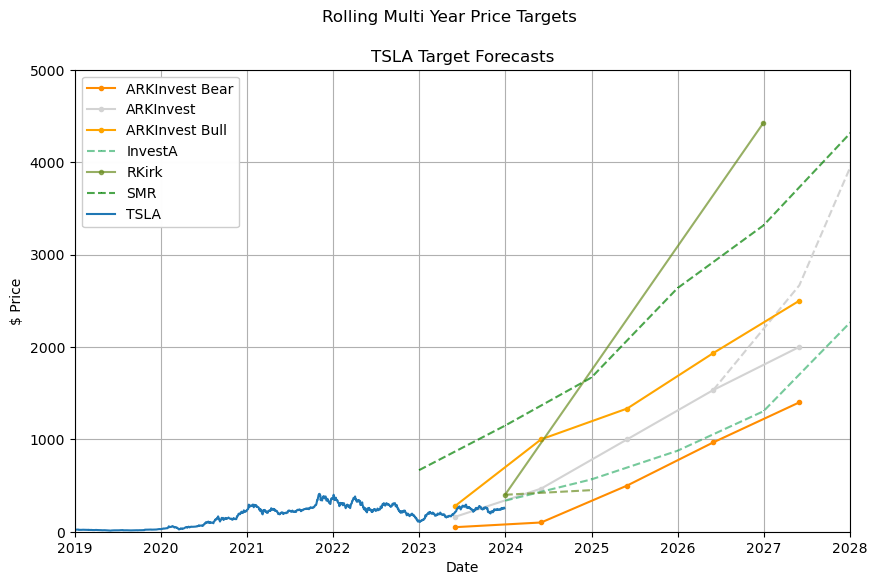

In [204]:
import matplotlib.cm as cm
import numpy as np

# Extend the four year forecast to the end of the data
extendFourYear = False
# Show other forecasts (in addition to ARK)
showOther = True

if not showOther:
    dfTargets = dfTargets[dfTargets['Source'] == 'ARKInvest']

dfTargets = dfTargets.sort_values(['Source', 'ForecastDate', 'TargetDate'])

plt.figure(figsize=(10, 6))

grouped = dfTargets.groupby(['Source'])
for name, group in grouped:
    if name[0] == 'ARKInvest':
        line_color = colors['ark']
        line_alpha = 1
    else:
        rng_color = colors['other'].pop(0)
        colors['other'].append(rng_color)
        line_color = {
            'bear': rng_color,
            'base': rng_color,
            'bull': rng_color,
        }
        line_alpha = 0.7
        print(name[0]+ ' uses ' + rng_color)
            
    # Plot rolling ongoing forecast eg 4 year forecast updated each year
    rolling_forecast = group.drop_duplicates('ForecastDate')

    # Plot extended forecasts that have the same 'ForecastDate'
    extended_forecast = group.groupby(['ForecastDate'])


    for extended_name, subgroup in extended_forecast:
        if subgroup['Base'].notna().sum() > 1:
            if len(rolling_forecast) > 1:
                label_text = None # Hide label for extended forecasts if rolling forecast is also shown
            else:
                label_text = name[0]
            plt.plot(subgroup.index, subgroup['Base'], linestyle='dashed', marker=',', label=label_text, color=line_color['base'], alpha=line_alpha)

    if len(rolling_forecast) > 1:
        if group['Bear'].notna().sum() > 1:
            plt.plot(rolling_forecast.index, rolling_forecast['Bear'], marker='.', label=name[0]+' Bear', color=line_color['bear'], alpha=line_alpha)
        if group['Base'].notna().sum() > 1:
            plt.plot(rolling_forecast.index, rolling_forecast['Base'], marker='.', label=name[0], color=line_color['base'], alpha=line_alpha)
        if group['Bull'].notna().sum() > 1:
            plt.plot(rolling_forecast.index, rolling_forecast['Bull'], marker='.', label=name[0]+' Bull', color=line_color['bull'], alpha=line_alpha)   

plt.plot(df.index, df['Price'], color=colors['tsla'], label='TSLA')
plt.xlabel('Date')
plt.ylabel('$ Price')
plt.suptitle('Rolling Multi Year Price Targets')
plt.title('TSLA Target Forecasts')
plt.yticks(range(0, 100000, 1000))
plt.grid(True)

if extendFourYear:
    right_limit = pd.to_datetime('2031-01-01')
    top_limit = 11000
else:
    right_limit = pd.to_datetime('2028-01-01')
    top_limit = 5000
plt.ylim(bottom=0, top=top_limit) 
plt.xlim(left=pd.to_datetime('2019-01-01'), right=right_limit)

#plt.yscale('linear')
legend = plt.legend(loc='best')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.98)
plt.show()

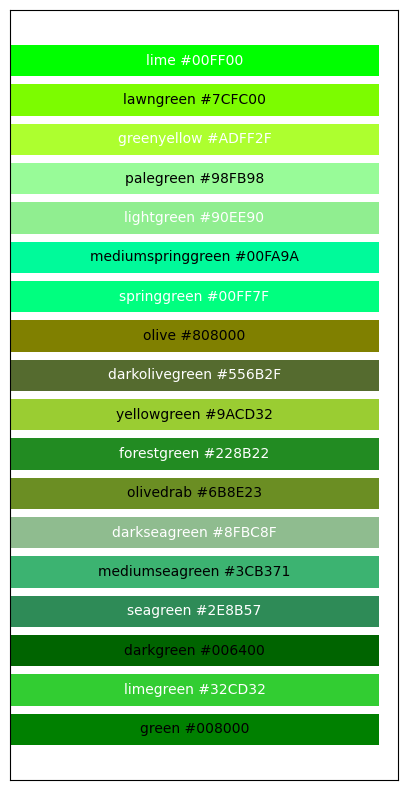

In [205]:
import matplotlib.pyplot as plt

colors = {
    'green': '#008000',
    'limegreen': '#32CD32',
    'darkgreen': '#006400',
    'seagreen': '#2E8B57',
    'mediumseagreen': '#3CB371',
    'darkseagreen': '#8FBC8F',
    'olivedrab': '#6B8E23',
    'forestgreen': '#228B22',
    'yellowgreen': '#9ACD32',
    'darkolivegreen': '#556B2F',
    'olive': '#808000',

    'springgreen': '#00FF7F',
    'mediumspringgreen': '#00FA9A',

    # light green colors
    'lightgreen': '#90EE90',
    'palegreen': '#98FB98',

    # bright green colors
    'greenyellow': '#ADFF2F',
    'lawngreen': '#7CFC00',
    'lime': '#00FF00',
}

plt.figure(figsize=(5, 10))

for i, (name, hex) in enumerate(colors.items()):
    plt.barh(i, 1, color=hex)
    plt.text(0.5, i, name + ' ' + hex, ha='center', va='center', color='black' if i % 2 == 0 else 'white')

plt.yticks([])
plt.xticks([])
plt.show()

### Disclaimer

Not financial advice: All content of this repository is for educational purposes only. No warranty or guarantee or forward looking statements of fit for purpose; do your own research, etc.